

```
# Setup
```

In [ ]:
!nvidia-smi # runtime T4 GPU ашиглана

# --- Гол libraries суулгах
!pip -q install -U "transformers[torch]" datasets accelerate peft sentencepiece evaluate rouge_score bitsandbytes wandb

# --- Import test хийх, version -г хэвлэх
import torch, transformers, datasets, peft, evaluate
print("Torch:", torch.__version__)
print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("PEFT:", peft.__version__)



Mon Nov 10 05:06:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# --- Hugginface -руу нэтврэх
from huggingface_hub import login
login()

In [ ]:
from transformers import MBart50TokenizerFast

model_name = "facebook/mbart-large-50"

# Tokenizer -ийг ачааллах
tokenizer = MBart50TokenizerFast.from_pretrained(model_name, use_fast=True)
tokenizer.src_lang="mn_MN"

# Жишээ текст
mongolian_text = "Монгол хэлний өгүүлбэрийг токен болгох."
# mongolian_text = "Монголын Боловсол шинжлэх ухааны үйлдвэрчний эвлэлийн холбооны дарга З.Цогтгэрэл өнөөдөр /2025.09.23/ мэдэгдэл хийлээ. Энэ үеэрээ улс орон даяар маргааш /2025.09.24/ багш нарын цалинг 3.5 сая төгрөг болгохыг шаардан багш нар жагсах болсныг мэдэгдэв. Энэ үеэр багш нарын цалин хөлс, нийгмийн баталгааг сайжруулахыг шаардаж УИХ-ын дарга болон Ерөнхий сайд нарт шаардлага хүргүүлнэ. Уг шаардлагыг албан тушаалтнууд өөрийн биеэр хүлээн авахыг хүсэж байна. Мөн тайван жагсаал хийхдээ бусдын нэр хүндэд халдахгүй байхыг уриаллаа. Энэ удаагийн тайван жагсаал үр дүнд хүрэхгүй тохиолдолд хуулийнхаа хүрээнд тэмцэл хөдөлгөөнийг үргэлжлүүлэх болно гэв. Тайван жагсаалыг 12:00-16:00 цагийн хооронд зохион байгуулах юм."

# Tokenize
inputs = tokenizer(mongolian_text, return_tensors="pt", max_length=1024, truncation=True, padding=True)

print(f"Токен ID: {inputs['input_ids']}")
print(f"Нийт токен: {len(inputs['input_ids'][0])}")
# print(inputs)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Токен ID: tensor([[250037,   7053, 161648, 156357, 141961,   2553,    690,  14564,  72154,
              5,      2]])
Нийт токен: 11


# preprocess хийхийн өмнө schema -г бататгах
Load & inspect dataset

In [ ]:
from datasets import load_dataset

# 1) Load all splits
ds = load_dataset("amaraaa/mn_translated_cnn_extended")
print(ds)

# 2) Train split -ээс хэдэн мөрүүдийг шалгая
row = ds["train"][0]
print("id:", row["id"])
print("Бичвэр:", (row["article"] or "")[:200].replace("\n"," "))
print("Хураангуй (төрөл/урт):", type(row["highlights"]).__name__, len(row["highlights"]))
print("Эхний хураангуй:", row["highlights"][0])

# 3) Sanity checks - Алдаанаас сэргийлж шалгалт хийх (data sanity checks)
def summarize_split(name):
  d = ds[name]
  # Хоосон article байгаа эсэхийг шалгах
  empty_articles = sum(1 for r in d if not r["article"] or not r["article"].strip())
  # Хоосон highlights байгаа эсэхийг шалгах
  empty_highlights = sum(1 for r in d if not r"highlights" or not r["highlights".strip()])
  return {
      "rows": len(d),
      "empty_articles": empty_articles,
      "empty_highlights": empty_highlights,
  }

print("\nSanity:")
for split in ds.keys():
  print(split, summarize_split(split))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/559 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/7.08M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/380k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/367k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1862 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/106 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/95 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'article', 'highlights'],
        num_rows: 1862
    })
    validation: Dataset({
        features: ['id', 'article', 'highlights'],
        num_rows: 106
    })
    test: Dataset({
        features: ['id', 'article', 'highlights'],
        num_rows: 95
    })
})
id: 0000800d9058217f6509d7e63ad475e2de0da611
Бичвэр: . Ричард Спиллетт. Машинд цэнэглэж байх үед дэлбэрсэн электрон тамхи нь бүтээгдэхүүний аюулгүй байдлын талаар шинэ айдас төрүүлэв. 54 настай асран хамгаалагч Ким Тейлор машинаас гал болон өтгөн хар ут
Хураангуй (төрөл/урт): list 5
Эхний хураангуй: 54 настай Ким Тейлор төхөөрөмжөө Ford Mondeo машины арын суудалд залгаад орхижээ.

Sanity:
train {'rows': 1862, 'empty_articles': 0, 'empty_highlights': 0}
validation {'rows': 106, 'empty_articles': 0, 'empty_highlights': 0}
test {'rows': 95, 'empty_articles': 0, 'empty_highlights': 0}


# Build preprocessing - (model training -д зориулж өгөгдлийг бэлдэх)
* mT5 нь single target string хүлээж авдаг
* highlights -д мөр бүрт string list байгаа

1) Иймээс list -ийн агуулгыг newline -тай нэг text болгоно
2) inputs/targets -ийг tokenize хийнэ (consistent max lengths)

In [ ]:
from datasets import DatasetDict
from transformers import MBart50TokenizerFast

# --- Тохируулга хийх
model_name = "facebook/mbart-large-50"
max_source_length = 768
max_target_length = 160

# 1) Highlight -уудын list -ийг single string болгож join хийх
def join_highlights(example): # (example -> single record)
  bullets = example.get("highlights") or []
  bullets = [str(x).strip() for x in bullets if isinstance(x, str) and str(x).strip()]
  example["highlights_str"] = "\n".join(bullets)
  return example

# Функцийг split бүрийн record дээр ажилуулна
ds = ds.map(join_highlights, desc="Joining highlight bullets")

# 2) Tokenizer -ийг ачааллах
tokenizer = MBart50TokenizerFast.from_pretrained(model_name, use_fast=True)
tokenizer.src_lang = "mn_MN"
tokenizer.tgt_lang = "mn_MN"

# --- Tokenize хийх

# 3) Tokenize inputs & targets - (article, highlights)
def preprocess_batch(batch):

  # tokenize (бичвэр)
  model_inputs = tokenizer(
      batch["article"],
      max_length=max_source_length,
      truncation=True,
  )

  # tokenize (хураангуй)
  labels = tokenizer(
      batch["highlights_str"],
      max_length=max_target_length,
      truncation=True,
  )

  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

# cols_to_remove = list(set(ds["train"].column_names) - {"id"})
# Remove original columns and the joined highlights string, including 'id'
cols_to_remove = ["id", "article", "highlights", "highlights_str"]

tokenized_ds = ds.map(
    preprocess_batch,
    batched=True,
    remove_columns=cols_to_remove,
    desc="Tokenizing"
)

print(tokenized_ds)
print("Example ids:", tokenized_ds["train"][0]["input_ids"][:20], "...")
print("Example labels:", tokenized_ds["train"][0]["labels"][:20], "...")

# --- Tokenized хослолыг шалгах
sample = tokenized_ds["train"][0]
print(tokenizer.decode(sample["input_ids"], skip_special_tokens=True))

# Safe label preview: (replace -100 with pad id before decoding)
safe_labels = [(tid if tid != -100 else tokenizer.pad_token_id) for tid in sample["labels"]]
print(tokenizer.decode(safe_labels, skip_special_tokens=True))



Joining highlight bullets:   0%|          | 0/1862 [00:00<?, ? examples/s]

Joining highlight bullets:   0%|          | 0/106 [00:00<?, ? examples/s]

Joining highlight bullets:   0%|          | 0/95 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Tokenizing:   0%|          | 0/1862 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/106 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/95 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1862
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 106
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 95
    })
})
Example ids: [250037, 6, 5, 208710, 589, 54406, 7330, 222, 5, 114761, 526, 109429, 11404, 114903, 10468, 31356, 6, 70457, 1447, 222993] ...
Example labels: [250037, 8983, 123323, 97583, 6104, 312, 44264, 96501, 14522, 17652, 111651, 31, 94395, 6, 81805, 135, 47396, 24368, 51417, 132567] ...
. Ричард Спиллетт. Машинд цэнэглэж байх үед дэлбэрсэн электрон тамхи нь бүтээгдэхүүний аюулгүй байдлын талаар шинэ айдас төрүүлэв. 54 настай асран хамгаалагч Ким Тейлор машинаас гал болон өтгөн хар утаа гарч байгааг анзаарахаасаа өмнө аравхан минутын турш төхөөрөмжийг цэнэглэж орхижээ. Тухайн үед дотор нь хэн ч байгаагүй ч арын суудал бүрэн хайлж, хоёр

# Load mT5-small & attach LoRa adapters
LoRa гэх мэт PEFT method -оор model сургахдаа бэлдэх (peft configuration)

LoRa -> суурь model -ийг бүхэлд нь биш зөвхөн тодорхой цөөн weight -үүдийг сургана.
*   Resrource бага шаардана
*   Илүү efficient байх боломжтой
*   Model -ийн цөөн тооны parameter -ийг үр дүнтэй fine-tune хийнэ.
*   Computational болон storage cost багасгана.


In [ ]:
import torch
from transformers import AutoModelForSeq2SeqLM
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training # Added prepare_model_for_kbit_training

#1) Load base model
base_model_name = "facebook/mbart-large-50"
model = AutoModelForSeq2SeqLM.from_pretrained(base_model_name)
# GPU -рүү шилжүүлэх
model.to("cuda")
print(next(model.parameters()).device)

# Resize token embeddings to account for all tokenizer tokens, including special language tokens
new_vocab_size = len(tokenizer)
model.resize_token_embeddings(new_vocab_size)

# Manually resize model.final_logits_bias for MBart-style models, as it's not automatically resized
if hasattr(model, 'final_logits_bias') and model.final_logits_bias is not None:
    current_bias_size = model.final_logits_bias.shape[-1]
    if current_bias_size < new_vocab_size:
        # Create a new bias tensor with the correct size, padding with zeros
        new_final_logits_bias = torch.zeros(1, new_vocab_size)
        new_final_logits_bias = new_final_logits_bias.to(model.final_logits_bias.device)
        new_final_logits_bias[0, :current_bias_size] = model.final_logits_bias
        model.final_logits_bias = new_final_logits_bias
    elif current_bias_size > new_vocab_size:
        # Trim if for some reason new_vocab_size is smaller (unlikely here)
        model.final_logits_bias = model.final_logits_bias[..., :new_vocab_size]

mn_id = tokenizer.lang_code_to_id["mn_MN"]
model.config.forced_bos_token_id = mn_id
model.config.decoder_start_token_id = mn_id

model.gradient_checkpointing_enable() # reduces VRAM
model.config.use_cache = False

# k-bit prep (casts layer norms to fp32 etc.)
# This is crucial for gradient checkpointing and LoRA compatibility.
model = prepare_model_for_kbit_training(model) # Uncommented and applied

#3) LoRa config тохируулах
peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=8, # rank
    lora_alpha=16, #scaling
    lora_dropout=0.15, # (overfitting бууруулна)
    target_modules=["q_proj", "v_proj"], # Bart attention projections
    bias="none",
)

#4) (BART -д loRa technique -ийг apply хийнэ)
model = get_peft_model(model, peft_config)

#5) Хэчнээн params сургахаа харах
model.print_trainable_parameters()

cuda:0
trainable params: 1,179,648 || all params: 612,059,136 || trainable%: 0.1927


# Trainer тохируулга (metrics, collator, hyperparams)
Rouge metrics, batching/padding, hyperparameters тохируулах


In [ ]:
import numpy as np
import evaluate
from transformers import(
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    EarlyStoppingCallback,
)

#1) Metric: ROUGE
rouge = evaluate.load("rouge")

def postprocess_text(preds, labels):
  # strip хийгээд sentence хоороod newline нэмэх
  preds = [p.strip() for p in preds]
  labels = [l.strip() for l in labels]
  return preds, labels

def compute_metrics(eval_pred):
  preds, labels = eval_pred

  # Some trainers return (sequences)
  if isinstance(preds, tuple):
      preds = preds[0] #take token IDs matrix

  # IMPORTANT: decode хийхээс өмнө ignore index (-100) -г real pad token ID -аар солих
  #preds
  if isinstance(preds, np.ndarray):
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
  else:
    # fallback in case preds is a list
    preds = [[(tok if tok != -100 else tokenizer.pad_token_id) for tok in seq] for seq in preds]
  #labels
  if isinstance(labels, np.ndarray):
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  else:
    # fallback in case labels is a list
    labels = [[(tok if tok != -100 else tokenizer.pad_token_id) for tok in seq] for seq in labels]

  # decode predictions
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  print(decoded_preds)

  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # light cleanup for ROUGE
  decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

  # Compute ROUGE
  result = rouge.compute(
      predictions=decoded_preds,
      references=decoded_labels,
      use_stemmer=True,
  )

  return {k: round(v * 100, 4) for k, v in result.items()}

#2) dynamic padding & label masking (-100)
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    label_pad_token_id=-100,
    pad_to_multiple_of=8 if torch.cuda.is_available() else None,
)

model.gradient_checkpointing_enable() # reduces VRAM

#3) Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="mbart_mn_lora",
    per_device_train_batch_size=16, #GPU дээр нэг удаад хэр их sample process хийх
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    learning_rate=1e-4, #LoRa -д тохиромжтой learning rate (1e-4 -> 5e-4)
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    predict_with_generate=True,
    generation_max_length=160,
    generation_num_beams=4, #давтамжийг багасгана, үр дүнг сайжруулна.
    warmup_ratio=0.15, #сургалтын явцад learning rate -ийг ихэсгэнэ
    lr_scheduler_type="constant_with_warmup",
    max_grad_norm=0.5,
    weight_decay=0.05, #overfitting үүсэхээс сэргийлнэ. data pattern -ийг сурахад илүү туслана.
    optim="paged_adamw_8bit", # 8-bit optimizer (bitsandbytes)
    logging_steps=25,
    load_best_model_at_end=True,
    metric_for_best_model="eval_rougeLsum",
    greater_is_better=True,
    save_total_limit=2,
    fp16=False,
    label_smoothing_factor=0.1,
    group_by_length=True,
    report_to=["none"],
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
    seed=42,
)

model.config.no_repeat_ngram_size = 3 # n-gram хослолыг дахиж давтахгүй
model.config.length_penalty = 1.0 # илүү урт хураангуй гаргах боломжийг олгоно

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Add early stopping (prevents overfitting on 369 rows)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2))

print("Ready to train.")
print("Train rows:", len(tokenized_ds["train"]), "| Val rows:", len(tokenized_ds["validation"]))

Ready to train.
Train rows: 1862 | Val rows: 106


/tmp/ipython-input-1219089206.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


# Sanity check before full training

In [ ]:
# Small slice of eval to test metrics & decoding path
small_eval = tokenized_ds["validation"].select(range(20))
eval_result = trainer.evaluate(eval_dataset=small_eval)

print(eval_result)


# Training эхлүүлэх - (LoRa on mT5-small)

In [ ]:
import os

# # ──────────────────────────────────────────────────────────────
# # Train → Evaluate
# # ──────────────────────────────────────────────────────────────
# print("Eval (before training):")
# metrics_before = trainer.evaluate()
# print(metrics_before)

# Training
train_result = trainer.train()

# Save the best checkpoint (load_best_model_at_the_end=True)
trainer.save_model("mbart_mn_lora/best") # saves LoRa adapter weights + config
tokenizer.save_pretrained("mbart_mn_lora/best")

# see a short summary of training
print(train_result)



Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,8.999300,5.931377,21.852400,7.600700,21.404600,21.395700
2,5.290200,4.663074,22.095800,6.044100,20.716400,20.666200
3,4.851500,4.494220,25.780400,6.579900,25.330700,25.463600
4,4.718900,4.412990,25.502600,5.941700,24.942200,24.909100
5,4.691900,4.379176,27.669200,8.544100,26.591900,26.825900
6,4.632300,4.328086,25.966300,7.580700,25.132600,25.452300
7,4.610100,4.301559,25.329300,8.051000,24.879100,24.948800


['(CNN) Би бол Кандида Мосс, Нотр Дамын Их Сургуулийн Шинэ Гэрээ ба Эрт Христийн шашны профессор. Би "Жинхэнэ загалмай" цувралын зөвлөхөөр ажиллаж байсан бөгөөд CNN-ийн "Есүсийг олох нь" цувралын камерын олон мэргэжилтнүүдийн нэгээр ажиллаж байсан бөгөөд одоо ням гаригт гарч байна. Үзэгчид шоуны үеэр "Есүсийг олох нь" фэйсбүүк хуудсанд жиргэж, асуусан асуултаа нийтлэхийг урьсан. Үзэгчид шоуны үеэр "Есүсийг олох нь" фэйсбүүк хуудсанд жиргэж, асуусан асуултаа нийтлэхийг урьсан.', 'Уучлаарай: Дэвид Дакенфилд Хилсборогийн гамшигт уучлалт гуйх боломж хэзээ ч байгаагүй гэж хэлэв. Хиллсборогийн гамшгийн үеэр үүрэг гүйцэтгэж байсан цагдаагийн дарга өнөөдөр албан тушаалтнуудаас худал хэлснийхээ төлөө уучлалт гуйж байгаагүй, учир нь ийм боломж олдохгүй байсан гэж мэдэгджээ. Дэвид Дакенфилд 1989 оны 4-р сард Английн цомын тэмцээний хагас шигшээ тоглолтын үеэр Ливерпүүлийн 96 хөгжөөн дэмжигч нас барсан хэргийн мөрдөн байцаалтад өөрийгөө буруу мэдээлэл өгөх вий гэж санаа зовсондоо дуугараагүй гэж х

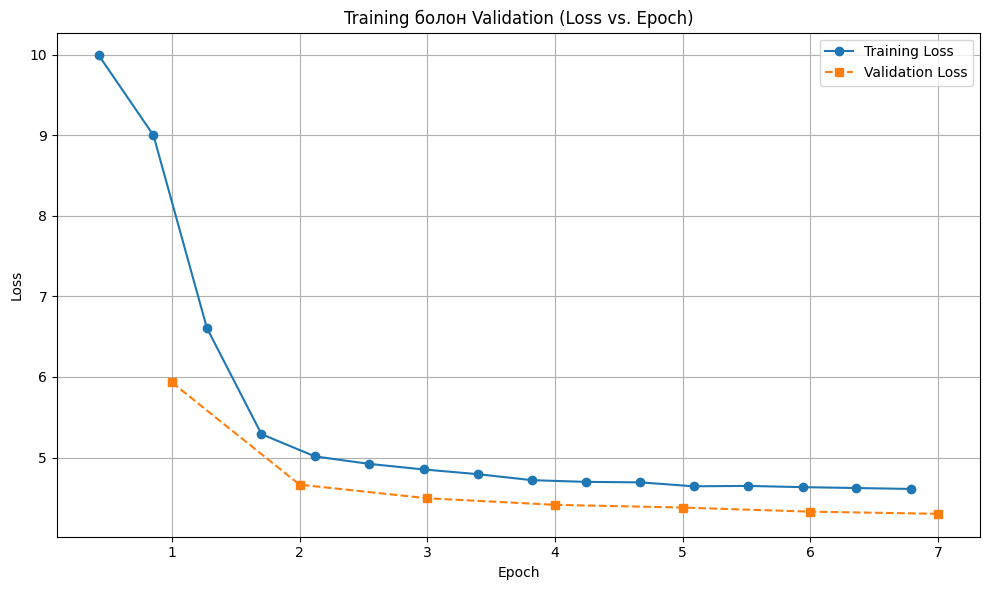

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# fine-tuning дууссаны дараа
def plot_training_loss(trainer):
    """
    Trainer object -ийн history -гоос (training loss/ validation loss) -ийг авах
    """
    # Extract the log history from the trainer state
    history = trainer.state.log_history

    # Convert history list to a pandas DataFrame for easier manipulation
    df = pd.DataFrame(history)

    # Filter for training loss entries
    # The key names might vary slightly ('loss', 'train_loss', 'eval_loss', etc.)
    train_loss_df = df.dropna(subset=['loss'])

    # Filter for validation loss entries
    eval_loss_df = df.dropna(subset=['eval_loss'])

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot training loss
    if not train_loss_df.empty:
        plt.plot(train_loss_df['epoch'], train_loss_df['loss'], label='Training Loss', marker='o', linestyle='-')

    # Plot validation loss
    if not eval_loss_df.empty:
        # We need to map evaluation steps to the correct epoch values
        plt.plot(eval_loss_df['epoch'], eval_loss_df['eval_loss'], label='Validation Loss', marker='s', linestyle='--')

    plt.title('Training болон Validation (Loss vs. Epoch)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- How to use it ---
# After you run your trainer.train() command, call the function:

# Example usage (commented out as the trainer object is not defined here):
plot_training_loss(trainer)


In [ ]:
# Eval after training (this will load the best model due to load_best_model_at_end=True)
print("Eval (after training - best validation model):")
best_validation_metrics = trainer.evaluate(eval_dataset=tokenized_ds["validation"])
print(best_validation_metrics)

# Store the best validation metrics globally
%store best_validation_metrics

Eval (after training - best validation model):


['Английн түүхэн дэх хамгийн том хувийн наймаануудын нэг болох 20 сая фунт стерлингийн үнэ бүхий сонгодог автомашины эрдэнэсийг дилерүүд олж авчээ. Жон Коллинз Ferrari, Mercedes, Porsche, Lamborghini зэрэг 27 автомашины загваруудыг багтаасан гайхалтай цуглуулгыг худалдан авчээ. Тээврийн хэрэгслийн дунд Aston Martin One-77 болон Ferrari 288 GTO байгаа бөгөөд одоогоор хамгийн хурдан үнэлэгдсэн сонгодог загваруудын нэг юм.', 'Бидний цөөхөн хүн тэднийг Твиттерээр шууд дамжуулж чадахуйц сонирхолтой амьдралтай байдаг ч шинэ програм нь бидэнд сонголт хийх боломжийг олгодог. Meerkat нь таны утсыг зөөврийн вэб камер болгон хувиргаж, гар утасныхаа камер руу чиглүүлсэн бүх бичлэгийг шууд дамжуулах боломжийг олгодог. Мөн энэ нь Twitter-тэй холбогддог учраас хэрэглэгчид аль хэдийн тусгайлсан үзэгчидтэй болсон. Meerkat нь таны утсыг зөөврийн вэб камер болгон хувиргаж, гар утасныхаа камерыг тухайн газар руу чиглүүлж, дамжуулах холбоосыг холбогдсон бүртгэлээс автоматаар жиргэх болно. Энэхүү програмыг 

# Test dataset дээр эцсийн evaluation хийх

In [ ]:
test_eval = tokenized_ds["test"]
eval_result = trainer.evaluate(eval_dataset=test_eval)

print(eval_result)

['Нью Йорк хотын дарга Билл де Блазиогийн хүү Данте де Блазио Айви Лигийн Йел, Браун зэрэг хэд хэдэн шилдэг коллежид элссэн гэж Грэйси Харшийн ойрын эх сурвалж мэдээллээ. Хотын даргын хүү 17 настай, Бруклиний Техникийн ахлах сургуулийн ахлах ангийн сурагч энэ сарын сүүл гэхэд шийдвэрээ гаргаж, де Блазиог улс даяар сая сая хүнд танил болсон нөхцөл байдалд үлдээнэ. Хотын даргаар ажиллаж байхдаа зургаан хувийн цалинтай, эхнэрийнхээ хамт Бруклинд эзэмшдэг хоёр үл хөдлөх хөрөнгийн түрээсийн орлоготой байсан ч де Блазио хүүгийнхээ элит боловсролыг төлөхийн тулд санхүүгийн тусламж авахаар болжээ.', 'Түүний хөршх лейландийн хашаа нь 40 фут өндөр бөгөөд Одри Александрын хэлснээр цэцэрлэгийнхээ зарим хэсгийг гүн сүүдэрт үлдээжээ. Тэгээд ч энэ хэвээрээ л байх шиг байна. Модыг хэмжээгээр нь тайрахын тулд 35 жил тэмцсэн хэдий ч зөвлөл тэднийг үлдэх боломжтой гэж үзжээ. Энэ бол Хатагтай Александрын гэр бүлийн хоёр үеийг хамарсан тулалдаанд эцсийн ялагдал юм.', 'Энэ бүх цаг үеийн хамгийн гайхамшигтай

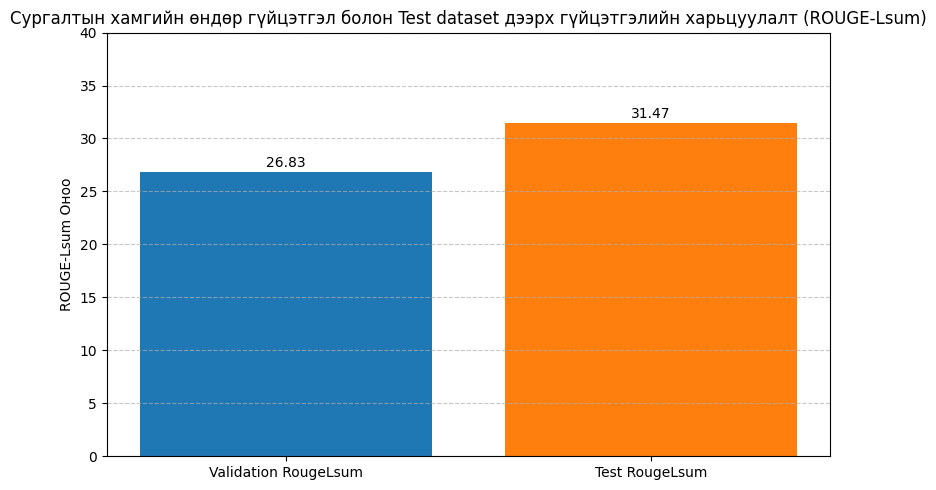

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Retrieve the globally stored best_validation_metrics
# We assume eval_result is from the test set evaluation and is available in the current scope

# Extract RougeLsum for comparison
val_rougeLsum = best_validation_metrics['eval_rougeLsum']
test_rougeLsum = eval_result['eval_rougeLsum']

# Data for plotting
metrics_data = {
    'Metric': ['Validation RougeLsum', 'Test RougeLsum'],
    'Score': [val_rougeLsum, test_rougeLsum]
}
df_comparison = pd.DataFrame(metrics_data)

# Create the bar chart
plt.figure(figsize=(8, 5))
bar_colors = ['#1f77b4', '#ff7f0e'] # Different colors for distinction
plt.bar(df_comparison['Metric'], df_comparison['Score'], color=bar_colors)

plt.ylabel('ROUGE-Lsum Оноо')
plt.title('Сургалтын хамгийн өндөр гүйцэтгэл болон Test dataset дээрх гүйцэтгэлийн харьцуулалт (ROUGE-Lsum)')
plt.ylim(0, 40) # Adjust y-axis limit based on expected ROUGE scores

# Optional: Add the exact value on top of each bar
for index, row in df_comparison.iterrows():
    plt.text(row['Metric'], row['Score'] + 0.5, f"{row['Score']:.2f}", ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Сургасан model -оо хадгалах

#1) Google Drive -руу хадгалах
SAVE_DIR = "/content/drive/MyDrive/mBART-50_finetuned_v1"

from google.colab import drive
drive.mount('/content/drive')

trainer.save_model(SAVE_DIR) # with PEFT: saves LoRA adapter + peft_config.json
tokenizer.save_pretrained(SAVE_DIR) # tokenizer files
model.config.save_pretrained(SAVE_DIR)
print("Saved to:", SAVE_DIR)


Mounted at /content/drive
Saved to: /content/drive/MyDrive/mBART-50_finetuned_v1


/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 250037}
  warnings.warn(


In [ ]:
from huggingface_hub import login
login()  # paste your HF token when prompted (Settings → Access Tokens)


In [ ]:
# Paths — adjust if different
ADAPTER_DIR = "mbart_mn_lora/best"        # where trainer.save_model(...) wrote your LoRA adapter
MERGED_DIR  = "mbart_mn_merged"           # where we’ll write the fully merged model

# Hugging Face repo info — choose a clean, final model name
HF_REPO     = "amaraaa/mbart50-mn-summarization_v1"
PRIVATE     = False  # set True if you want the repo private


In [ ]:
import json, os

cfg_path = os.path.join(ADAPTER_DIR, "adapter_config.json")
with open(cfg_path, "r", encoding="utf-8") as f:
    adapter_cfg = json.load(f)

base_model_id = adapter_cfg.get("base_model_name_or_path", "facebook/mbart-large-50")
peft_type     = adapter_cfg.get("peft_type", "LORA")

print("Detected base model:", base_model_id)
print("PEFT type:", peft_type)
assert peft_type.upper() == "LORA", "This script assumes a LoRA adapter."


Detected base model: facebook/mbart-large-50
PEFT type: LORA


# Load base, attach adapter, merge and unload

In [ ]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from peft import PeftModel

# Always reload the base in full precision for a safe merge
model = AutoModelForSeq2SeqLM.from_pretrained(
    base_model_id,
    torch_dtype=torch.float32,      # full precision to merge
    low_cpu_mem_usage=True
)
tokenizer = AutoTokenizer.from_pretrained(base_model_id, use_fast=True)

# Attach LoRA adapter
model = PeftModel.from_pretrained(model, ADAPTER_DIR, is_trainable=False)

# Merge LoRA weights into the base and drop PEFT hooks
merged_model = model.merge_and_unload()   # <- critical step

# Optional but often helpful for seq2seq:
# If you used language codes during training (mbart requires them),
# preserve the same forced_bos_token_id you trained with (if any).
# The 'mn_id' variable holds the language token ID set during training.
merged_model.config.forced_bos_token_id = mn_id # Ensure this is explicitly set
merged_model.config.decoder_start_token_id = mn_id # Ensure this is explicitly set


In [ ]:
# mn_mn_id = tokenizer.lang_code_to_id["mn_MN"]
# print(mn_mn_id)
print(mn_id)

250037


# Save the merged model locally (safe tensors) + generation config

In [ ]:
from transformers import GenerationConfig

# Save model + tokenizer
merged_model.save_pretrained(MERGED_DIR, safe_serialization=True)
tokenizer.save_pretrained(MERGED_DIR)

# Optionally save your preferred generation defaults (adjust to your training/eval choices)
gen_config = GenerationConfig(
    max_new_tokens=160,
    num_beams=4,
    length_penalty=1.0,
    early_stopping=True
)
gen_config.save_pretrained(MERGED_DIR)

print("Saved:", MERGED_DIR)


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_bos_token_id': 250037}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Saved: mbart_mn_merged


In [ ]:
import os, glob
MERGED_DIR = "mbart_mn_merged"  # or whatever you used above
print("cwd:", os.getcwd())
print("exists:", os.path.isdir(MERGED_DIR))
print("contents (first 20):")
for p in sorted(glob.glob(f"{MERGED_DIR}/**/*", recursive=True)):
    print(" ", p)


cwd: /content
exists: True
contents (first 20):
  mbart_mn_merged/config.json
  mbart_mn_merged/generation_config.json
  mbart_mn_merged/model.safetensors
  mbart_mn_merged/sentencepiece.bpe.model
  mbart_mn_merged/special_tokens_map.json
  mbart_mn_merged/tokenizer.json
  mbart_mn_merged/tokenizer_config.json


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

model_id = HF_REPO  # e.g., "username/mbart50-mn-summarization-lora-merged"
tok = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

# If you used language codes during training, set them now:
# tok.src_lang = "en_XX"; tok.tgt_lang = "en_XX"

pipe = pipeline("summarization", model=model, tokenizer=tok, device_map="auto")
pipe("Монголын Боловсол шинжлэх ухааны үйлдвэрчний эвлэлийн холбооны дарга З.Цогтгэрэл өнөөдөр /2025.09.23/ мэдэгдэл хийлээ. Энэ үеэрээ улс орон даяар маргааш /2025.09.24/ багш нарын цалинг 3.5 сая төгрөг болгохыг шаардан багш нар жагсах болсныг мэдэгдэв. Энэ үеэр багш нарын цалин хөлс, нийгмийн баталгааг сайжруулахыг шаардаж УИХ-ын дарга болон Ерөнхий сайд нарт шаардлага хүргүүлнэ. Уг шаардлагыг албан тушаалтнууд өөрийн биеэр хүлээн авахыг хүсэж байна. Мөн тайван жагсаал хийхдээ бусдын нэр хүндэд халдахгүй байхыг уриаллаа. Энэ удаагийн тайван жагсаал үр дүнд хүрэхгүй тохиолдолд хуулийнхаа хүрээнд тэмцэл хөдөлгөөнийг үргэлжлүүлэх болно гэв. Тайван жагсаалыг 12:00-16:00 цагийн хооронд зохион байгуулах юм. Багш нарын цалин хөлсийг нэмэгдүүлэх шаардлагыг тус холбооноос тавьж, улмаар Боловсролын яамныхантай хэлцэлд ч орсон. Боловсролын сайд П.Наранбаяр “Багш нарын үндсэн цалинг 3.5 сая төгрөг болгон нэмэгдүүлэхэд 3.3 их наяд төгрөг шаардлагатай. Энэ эх үүсвэрийг ирэх онд гаргах боломжгүй. Үе шаттай багш нарын цалинг нэмэх боломж бий” гэж мэдэгдээд байгаа.")


Confirm the merged model produces equivalent outputs to the adapter-attached model.

In [ ]:
from huggingface_hub import upload_folder

repo_id = "amaraaa/mbart50-mn-summarization_v1"
upload_folder(
    repo_id=repo_id,
    folder_path=MERGED_DIR,
    commit_message="Add merged mBART-50 Mongolian summarization model",
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...d/sentencepiece.bpe.model:  98%|#########7| 4.96MB / 5.07MB            

  ..._merged/model.safetensors:   0%|          | 1.05MB / 2.44GB            

  ..._mn_merged/tokenizer.json: 100%|##########| 17.1MB / 17.1MB            

CommitInfo(commit_url='https://huggingface.co/amaraaa/mbart50-mn-summarization_v1/commit/2070e325b6e542cc6ecad21387e3833f174604c4', commit_message='Add merged mBART-50 Mongolian summarization model', commit_description='', oid='2070e325b6e542cc6ecad21387e3833f174604c4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/amaraaa/mbart50-mn-summarization_v1', endpoint='https://huggingface.co', repo_type='model', repo_id='amaraaa/mbart50-mn-summarization_v1'), pr_revision=None, pr_num=None)